In [3]:
# !pip install snowflake-connector-python

     |████████████████████████████████| 16.4 MB 30.0 MB/s            
     |████████████████████████████████| 192 kB 84.7 MB/s            
     |████████████████████████████████| 2.0 MB 78.0 MB/s            


In [1]:
import pandas as pd
import numpy as np
import itertools as it
import os
import io
import logging

import boto3
import sys
import json

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

def func(x, a, b, c):
    return a * np.exp(-b * x) + c

x = [1.0, 2.0, 6.0]
y = [1, 0.5, 0.1]

popt, pcov = curve_fit(func, x, y)

/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/scipy/optimize/minpack.py:829: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


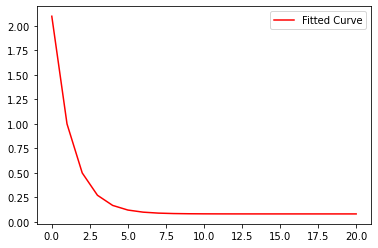

In [3]:
x = np.linspace(0,20,21)
y = func(x, *popt)
plt.figure()
plt.plot(x, y, 'r-', label="Fitted Curve")
plt.legend()
plt.show()

In [4]:
log_df = pd.DataFrame(list(zip(x, y)),
               columns =['x', 'y'])
log_df

,x,y
0,0.0,2.098138
1,1.0,1.000000
2,2.0,0.500000
3,3.0,0.272342
4,4.0,0.168686
5,5.0,0.121489
6,6.0,0.100000
7,7.0,0.090216
8,8.0,0.085761
9,9.0,0.083732


In [5]:
output_bucket = 'hbo-outbound-datascience-content-dev'

In [6]:
def to_s3(filename, output_bucket, content):
    client = boto3.client('s3')
    client.put_object(Bucket=output_bucket, Key=filename, Body=content)

In [7]:

csv_buffer = io.StringIO()
log_df.to_csv(csv_buffer, index = False)
content = csv_buffer.getvalue()

filename = 'output_percent_actives/log_function_value.csv'

to_s3(filename, output_bucket, content)

/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/boto3/compat.py:88: PythonDeprecationWarning: Boto3 will no longer support Python 3.6 starting May 30, 2022. To continue receiving service updates, bug fixes, and security updates please upgrade to Python 3.7 or later. More information can be found here: https://aws.amazon.com/blogs/developer/python-support-policy-updates-for-aws-sdks-and-tools/
  warnings.warn(warning, PythonDeprecationWarning)


In [8]:
import os
import sys
import logging
import boto3
import itertools as it
import io
from utils import *
import snowflake.connector

In [9]:
from matplotlib.pyplot import figure
import matplotlib.pyplot as plt
from sklearn.model_selection import GroupKFold
import datetime
from datetime import timedelta
import scipy.stats as st

In [10]:
pd.set_option('display.max_rows', 1000)
pd.set_option('display.max_columns', None)
pd.options.mode.chained_assignment = None  # default='warn'

In [11]:
class SnowflakeConnector(BaseConnector):
    def __init__(self, credentials: Credentials):
        keys = credentials.get_keys()
        self._secrets = json.loads(keys.get('SecretString', "{}"))

    def connect(self, dbname: str, schema: str = 'DEFAULT'):
        ctx = snowflake.connector.connect(
            user=self._secrets['login_name'],
            password=self._secrets['login_password'],
            account=self._secrets['account'],
            warehouse=self._secrets['warehouse'],
            database=dbname,
            schema=schema
        )

        return ctx
    
## Credentials
SF_CREDS = 'datascience-max-dev-sagemaker-notebooks'

## Snowflake connection 
conn=SnowflakeConnector(SSMPSCredentials(SF_CREDS))
ctx=conn.connect("MAX_DEV","WORKSPACE")

/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/boto3/compat.py:88: PythonDeprecationWarning: Boto3 will no longer support Python 3.6 starting May 30, 2022. To continue receiving service updates, bug fixes, and security updates please upgrade to Python 3.7 or later. More information can be found here: https://aws.amazon.com/blogs/developer/python-support-policy-updates-for-aws-sdks-and-tools/
  warnings.warn(warning, PythonDeprecationWarning)


In [12]:
def run_query(query):
    cursor = ctx.cursor()
    cursor.execute(query)
    df = pd.DataFrame(cursor.fetchall(), columns = [desc[0] for desc in cursor.description])
    df.columns= df.columns.str.lower()
    return df

In [13]:
run_query('''
create or replace table max_prod.content_datascience.log_function_value (
x float,
y float
)
''')

ProgrammingError: 003001 (42501): SQL access control error:
Insufficient privileges to operate on schema 'CONTENT_DATASCIENCE'

# EDA

In [ ]:
contributor = run_query('''
SELECT contributor_name, c.title_id, category, roles, 
       t.ORIGINAL_TITLE, t.TITLE_TYPE,
       area.area_name, box.AREA_GROSS, box.NUMBER_OF_THEATRES
FROM "ENTERPRISE_DATA"."CATALOG"."IMDB_TITLE_CONTRIBUTOR" c
JOIN "ENTERPRISE_DATA"."CATALOG"."IMDB_TITLE" t  ON c.title_id = t.title_id
JOIN "ENTERPRISE_DATA"."CATALOG"."IMDB_BOXOFFICE_OPENING_WEEKENDS" box ON t.title_id = box.title_id
JOIN "ENTERPRISE_DATA"."CATALOG"."IMDB_AREA_CODES" area ON box.area_code = area.area_code
where c.PRINCIPAL_CAST_MEMBER = 1
AND box.area_code IN ('XDOM', 'XNDOM')
''')

In [41]:
len(contributor.title_id.unique())

20037

In [31]:
contributor.groupby(['area_name', 'contributor_name'])[['area_gross']].sum()\
            .groupby(['area_name'])\
            .apply(lambda x: x.sort_values(by = ['area_gross'], ascending=False).head(10))

area_gross
area_name                   area_name                   contributor_name                  
Domestic Reporting includes Domestic Reporting includes Samuel L. Jackson     2.174199e+09
                                                        Robert Downey Jr.     2.083208e+09
                                                        Scarlett Johansson    1.875898e+09
                                                        Chris Evans           1.600563e+09
                                                        Don Cheadle           1.544091e+09
                                                        Chris Hemsworth       1.495461e+09
                                                        Dwayne Johnson        1.354801e+09
                                                        Mark Ruffalo          1.331291e+09
                                                        Jeremy Renner         1.184531e+09
                                                        Morgan Freeman        1.127477e+09
International               International               Robert Downey Jr.     2.422842e+09
                                                        Scarlett Johansson    2.112929e+09
                                                        Chris Hemsworth       2.021362e+09
                                                        Chris Evans           1.981782e+09
                                                        Don Cheadle           1.972713e+09
                                                        Mark Ruffalo          1.767021e+09
                                                        Jeremy Renner         1.626640e+09
                                                        Chadwick Boseman      1.619605e+09
                                                        Benedict Cumberbatch  1.501831e+09
                                                        Emma Watson           1.412150e+09

In [35]:
contributor_hbo = run_query('''
SELECT contributor_name, c.title_id, category, roles, 
       t.ORIGINAL_TITLE, t.TITLE_TYPE,
       area.area_name, box.AREA_GROSS, box.NUMBER_OF_THEATRES
FROM "ENTERPRISE_DATA"."CATALOG"."IMDB_TITLE_CONTRIBUTOR" c
JOIN "ENTERPRISE_DATA"."CATALOG"."IMDB_TITLE" t  ON c.title_id = t.title_id
JOIN "ENTERPRISE_DATA"."CATALOG"."IMDB_BOXOFFICE_OPENING_WEEKENDS" box ON t.title_id = box.title_id
JOIN "ENTERPRISE_DATA"."CATALOG"."IMDB_AREA_CODES" area ON box.area_code = area.area_code
JOIN (select distinct title_name from max_prod.catalog.reporting_asset_dim) dim 
    on t.ORIGINAL_TITLE = dim.TITLE_NAME
where c.PRINCIPAL_CAST_MEMBER = 1
AND box.area_code IN ('XDOM', 'XNDOM')
''')

In [42]:
len(contributor_hbo.title_id.unique())

4859

In [46]:
contributor_hbo.sort_values(by = ['area_gross'], ascending = False).head(10)

,contributor_name,title_id,category,roles,original_title,title_type,area_name,area_gross,number_of_theatres
43543,Michelle Rodriguez,tt4630562,actress,"[""Letty""]",The Fate of the Furious,movie,International,443150534.0,63.0
43224,Kurt Russell,tt4630562,actor,"[""Mr. Nobody""]",The Fate of the Furious,movie,International,443150534.0,63.0
10207,Nathalie Emmanuel,tt4630562,actress,"[""Ramsey""]",The Fate of the Furious,movie,International,443150534.0,63.0
35495,Luke Evans,tt4630562,actor,"[""Owen""]",The Fate of the Furious,movie,International,443150534.0,63.0
37477,Tyrese Gibson,tt4630562,actor,"[""Roman""]",The Fate of the Furious,movie,International,443150534.0,63.0
36056,Jason Statham,tt4630562,actor,"[""Deckard""]",The Fate of the Furious,movie,International,443150534.0,63.0
12626,Ludacris,tt4630562,actor,"[""Tej Parker""]",The Fate of the Furious,movie,International,443150534.0,63.0
31655,Vin Diesel,tt4630562,actor,"[""Dom""]",The Fate of the Furious,movie,International,443150534.0,63.0
43074,Dwayne Johnson,tt4630562,actor,"[""Hobbs""]",The Fate of the Furious,movie,International,443150534.0,63.0
29345,Charlize Theron,tt4630562,actress,"[""Cipher""]",The Fate of the Furious,movie,International,443150534.0,63.0


In [36]:
contributor_hbo.groupby(['area_name', 'contributor_name'])[['area_gross']].sum()\
            .groupby(['area_name'])\
            .apply(lambda x: x.sort_values(by = ['area_gross'], ascending=False).head(10))

area_gross
area_name                   area_name                   contributor_name                
Domestic Reporting includes Domestic Reporting includes Dwayne Johnson      1.056076e+09
                                                        Morgan Freeman      1.003027e+09
                                                        Emma Watson         9.454697e+08
                                                        Daniel Radcliffe    8.629938e+08
                                                        Rupert Grint        8.350354e+08
                                                        Tyrese Gibson       8.244874e+08
                                                        Eddie Murphy        7.900787e+08
                                                        Will Smith          7.854394e+08
                                                        Hugh Jackman        7.696550e+08
                                                        Ian McKellen        7.655145e+08
International               International               Emma Watson         1.398150e+09
                                                        Daniel Radcliffe    1.216422e+09
                                                        Rupert Grint        1.206510e+09
                                                        Dwayne Johnson      1.056008e+09
                                                        Tyrese Gibson       1.008442e+09
                                                        Michelle Rodriguez  9.579222e+08
                                                        Ian McKellen        9.456824e+08
                                                        Vin Diesel          8.377663e+08
                                                        Jason Statham       8.285903e+08
                                                        Ludacris            7.396192e+08

### Additional Metrics:
#### Refs
#### Number of Theaters
#### KPIs related (first view, %actives)
#### Number of votes
#### 

In [39]:
# Give credits to the top talent (Samuel L. Jackson being the top)

# EDA on Votes:

In [114]:
contributor_votes_hbo = run_query('''
SELECT contributor_name, c.title_id, category, roles, 
       t.ORIGINAL_TITLE, t.TITLE_TYPE,
       number_of_votes, imdb_rating, production_release_date,
       YEAR as release_year
FROM "ENTERPRISE_DATA"."CATALOG"."IMDB_TITLE_CONTRIBUTOR" c
JOIN "ENTERPRISE_DATA"."CATALOG"."IMDB_TITLE" t  ON c.title_id = t.title_id
JOIN (select distinct title_name from max_prod.catalog.reporting_asset_dim) dim 
    on t.ORIGINAL_TITLE = dim.TITLE_NAME
where c.PRINCIPAL_CAST_MEMBER = 1
and t.title_id = 'tt7126948'
''')

In [ ]:
contributor_votes_hbo.to_csv('contributor_votes_hbo.cvs')

In [ ]:
len(contributor_hbo.title_id.unique())

In [ ]:
contributor_hbo.sort_values(by = ['number_of_votes'], ascending = False).head(10)

In [9]:
contributor_votes = run_query('''
SELECT contributor_name, 
       sum(number_of_votes) as votes, 
       avg(imdb_rating) as ratings
FROM "ENTERPRISE_DATA"."CATALOG"."IMDB_TITLE_CONTRIBUTOR" c
JOIN "ENTERPRISE_DATA"."CATALOG"."IMDB_TITLE" t  ON c.title_id = t.title_id
where c.PRINCIPAL_CAST_MEMBER = 1
group by contributor_name
ORDER BY votes desc
LIMIT 20
''')

In [10]:
contributor_votes

,contributor_name,votes,ratings
0,Samuel L. Jackson,22297700.0,6.650611
1,Morgan Freeman,19437879.0,7.005947
2,Brad Pitt,19214761.0,6.541364
3,Leonardo DiCaprio,18556954.0,6.934818
4,Robert Downey Jr.,16654409.0,6.758562
5,Tom Hanks,16443542.0,6.875114
6,Scarlett Johansson,16402771.0,6.711299
7,Robert De Niro,14269843.0,6.711146
8,Christian Bale,13865738.0,6.708333
9,Bruce Willis,13286843.0,6.659410


In [17]:
contributor_hbo_votes = run_query('''
SELECT contributor_name, 
       sum(number_of_votes) as votes, 
       avg(imdb_rating) as ratings
FROM "ENTERPRISE_DATA"."CATALOG"."IMDB_TITLE_CONTRIBUTOR" c
JOIN "ENTERPRISE_DATA"."CATALOG"."IMDB_TITLE" t  ON c.title_id = t.title_id
JOIN (select distinct title_name from max_prod.catalog.reporting_asset_dim) dim 
    on t.ORIGINAL_TITLE = dim.TITLE_NAME
where c.PRINCIPAL_CAST_MEMBER = 1
group by contributor_name
ORDER BY votes desc
LIMIT 20
''')
contributor_hbo_votes

,contributor_name,votes,ratings
0,Morgan Freeman,18043592.0,6.929508
1,Brad Pitt,13286415.0,6.930000
2,Leonardo DiCaprio,12991828.0,7.320000
3,Christian Bale,11817342.0,7.254286
4,Tom Hardy,11698565.0,7.405405
5,Tom Hanks,11044301.0,7.179245
6,Matt Damon,10715819.0,6.954167
7,Ian McKellen,10416739.0,7.426667
8,Bruce Willis,10193376.0,6.328302
9,Michael Caine,10005702.0,6.918000


In [ ]:
# Search by release year
# Search by talent age/gender (need to get more data on talent)
# 

# JOIN WITH META CREDITS

In [118]:
imdb_yearly_sum = run_query('''
select YEAR as release_year, sum(number_of_votes) as yearly_sum
from
"ENTERPRISE_DATA"."CATALOG"."IMDB_TITLE"
GROUP BY YEAR
''')

In [128]:
imdb_contributor = run_query('''
SELECT distinct contributor_name, c.title_id, category, roles, 
       t.ORIGINAL_TITLE, t.TITLE_TYPE,
       number_of_votes, imdb_rating, production_release_date,
       YEAR as release_year
FROM "ENTERPRISE_DATA"."CATALOG"."IMDB_TITLE_CONTRIBUTOR" c
JOIN "ENTERPRISE_DATA"."CATALOG"."IMDB_TITLE" t  ON c.title_id = t.REMAPPED_TITLE_ID
where c.PRINCIPAL_CAST_MEMBER = 1
and YEAR = 2020
''')

In [129]:
imdb_contributor = pd.merge(imdb_contributor, imdb_yearly_sum, on = ['release_year'])

In [130]:
imdb_contributor[imdb_contributor['original_title']=='Wonder Woman 1984'].sort_values(by = ['contributor_name'])

,contributor_name,title_id,category,roles,original_title,title_type,number_of_votes,imdb_rating,production_release_date,release_year,yearly_sum
16536,Amr Waked,tt7126948,actor,"[""Emir Said Bin Abydos""]",Wonder Woman 1984,movie,230450,5.4,2020-12-16,2020,28325220.0
2378,Chris Pine,tt7126948,actor,"[""Steve Trevor""]",Wonder Woman 1984,movie,230450,5.4,2020-12-16,2020,28325220.0
808,Connie Nielsen,tt7126948,actress,"[""Hippolyta""]",Wonder Woman 1984,movie,230450,5.4,2020-12-16,2020,28325220.0
7216,Gal Gadot,tt7126948,actress,"[""Diana Prince""]",Wonder Woman 1984,movie,230450,5.4,2020-12-16,2020,28325220.0
18493,Kristen Wiig,tt7126948,actress,"[""Barbara Minerva""]",Wonder Woman 1984,movie,230450,5.4,2020-12-16,2020,28325220.0
2451,Kristoffer Polaha,tt7126948,actor,"[""Handsome Man""]",Wonder Woman 1984,movie,230450,5.4,2020-12-16,2020,28325220.0
17918,Lilly Aspell,tt7126948,actress,"[""Young Diana""]",Wonder Woman 1984,movie,230450,5.4,2020-12-16,2020,28325220.0
9471,Natasha Rothwell,tt7126948,actress,"[""Carol (Co-Worker)""]",Wonder Woman 1984,movie,230450,5.4,2020-12-16,2020,28325220.0
17481,Pedro Pascal,tt7126948,actor,"[""Maxwell Lord""]",Wonder Woman 1984,movie,230450,5.4,2020-12-16,2020,28325220.0
3509,Robin Wright,tt7126948,actress,"[""Antiope""]",Wonder Woman 1984,movie,230450,5.4,2020-12-16,2020,28325220.0


In [131]:
imdb_contributor['standardized_votes'] = imdb_contributor['number_of_votes'].astype(int)/imdb_contributor['yearly_sum']*100000

In [1]:
imdb_contributor.head()

NameError: name 'imdb_contributor' is not defined

### META info

In [115]:
meta_cast = run_query('''
SELECT distinct DISPLAY_TITLE_FULL as title_name, CAST_AND_CREW, 'Series' AS content_category
FROM ENTERPRISE_DATA.CATALOG.WM_META_ESB_SERIES_DIM
WHERE ACTIVE_FLAG = 'Y'

UNION

SELECT distinct title_name, CAST_AND_CREW, 'Movie' AS content_category
FROM ENTERPRISE_DATA.CATALOG.WM_META_ESB_EDIT_DIM
WHERE ACTIVE_FLAG = 'Y'
''')

In [116]:
def extract_language(row):
    json_df = pd.json_normalize(row)
    return json_df[json_df['language'] == 'en-US']['creditEntries'].values[0]

In [117]:
def add_element(row):   
    for element in row['cast_and_crew']:
        element['title_name'] = row['title_name']
    return row

In [118]:
test = meta_cast[meta_cast['cast_and_crew'] != '[]'].head(10).copy()
cast_crew = test['cast_and_crew'].apply(json.loads)
df = cast_crew.apply(extract_language)
test = test.drop(['cast_and_crew'], axis = 1).join(df)
test = test.apply(lambda row: add_element(row), axis = 1)


In [119]:
cast_order=pd.DataFrame()
for i in test['cast_and_crew']:
    json_df = pd.json_normalize(i)
    cast_order = pd.concat([cast_order, json_df])

In [120]:
cast_order = pd.read_csv('Talent_Billing_Order.csv')

In [121]:
cast_order.drop(['Unnamed: 0'], axis = 1, inplace = True)

In [122]:
cast_order.head()

,billingOrder,creditDisplay,creditType,firstName,lastName,participantId,title_name,characterName
0,1,Director,Director,Antoine,Fuqua,3474,What's My Name: Muhammad Ali - Part 2,NaN
1,1,Actor,Cast,Kareem,Abdul-Jabbar,43482,What's My Name: Muhammad Ali - Part 2,Self (archive footage) (as Lew Alcindor)
2,1,Editorial,Editorial,Jake,Pushinsky,16020,What's My Name: Muhammad Ali - Part 2,NaN
3,1,Music,Music,Marcelo,Zarvos,176501,What's My Name: Muhammad Ali - Part 2,NaN
4,1,Producer,Producer,Maverick,Carter,176502,What's My Name: Muhammad Ali - Part 2,NaN


In [125]:
cast_order['logged_order'] = func(cast_order['billingOrder'], *popt)

In [128]:
cast_order.tail()

,billingOrder,creditDisplay,creditType,firstName,lastName,participantId,title_name,characterName,logged_order
544441,6,Voice,Cast,Rene,Mujica,58435,Live and Let Diet,Newt,0.100000
544442,7,Voice,Cast,Alicyn,Packard,180165,Live and Let Diet,Toodles,0.090216
544443,8,Voice,Cast,Joey,D'Auria,180167,Live and Let Diet,Butch,0.085761
544444,9,Voice,Cast,Sam,Kwasman,180170,Live and Let Diet,Little Quacker,0.083732
544445,10,Voice,Cast,Grey,DeLisle Griffin,177807,Live and Let Diet,Ginger,0.082809


In [11]:
def log_order(row):
    row['logged_order'] = func(row['billingOrder'], *popt)
    return row

In [12]:
cast_order['logged_order'] = func(cast_order['billingOrder'], *popt)

In [54]:
cast_order['title_name'] = cast_order['title_name'].str.replace(',', '')
cast_order['characterName'] = cast_order['characterName'].str.replace(',', '')
cast_order['firstName'] = cast_order['firstName'].str.replace(',', '')
cast_order['lastName'] = cast_order['lastName'].str.replace(',', '')

In [37]:
cast_order['billingOrder'] = pd.to_numeric(cast_order['billingOrder'])

In [65]:
cast_order[cast_order['title_name'] == 'title_name']

,billingOrder,creditDisplay,creditType,firstName,lastName,participantId,title_name,characterName,logged_order


### Write csvs to S3

In [55]:
output_bucket = 'hbo-outbound-datascience-content-dev'

In [56]:
def to_s3(filename, output_bucket, content):
    client = boto3.client('s3')
    client.put_object(Bucket=output_bucket, Key=filename, Body=content)

In [57]:
csv_buffer = io.StringIO()
cast_order.to_csv(csv_buffer, index = False)
content = csv_buffer.getvalue()

filename = 'talent_data/talent_billing_order.csv'

to_s3(filename, output_bucket, content)

### Upload csv to sf

In [58]:
cast_order['logged_order'].dtypes

dtype('float64')

In [81]:
run_query('''
create or replace table max_Dev.workspace.content_data_science_talent_billing_order (
      billingOrder string
    , creditDisplay string
    , creditType string
    , firstName string
    , lastName string
    , participantId string
    , title_name string
    , characterName string
    , logged_order string
)
''')

,status
0,Table CONTENT_DATA_SCIENCE_TALENT_BILLING_ORDE...


In [82]:
stage = "@HBO_OUTBOUND_DATASCIENCE_CONTENT_DEV"

In [83]:
run_query('''
copy into max_Dev.workspace.content_data_science_talent_billing_order
    from(
        select
              $1
            , $2
            , $3
            , $4
            , $5
            , $6
            , $7
            , $8
            , $9
        from @HBO_OUTBOUND_DATASCIENCE_CONTENT_DEV/talent_data/talent_billing_order.csv
        )
    file_format = (type = csv null_if=(''))
    on_error = 'CONTINUE';

'''.format(stage = stage))

,file,status,rows_parsed,rows_loaded,error_limit,errors_seen,first_error,first_error_line,first_error_character,first_error_column_name
0,s3://hbo-outbound-datascience-content-dev/tale...,LOADED,544447,544447,544447,0,None,None,None,None


## Final Ranking

In [132]:
imdb_contributor.head()

,contributor_name,title_id,category,roles,original_title,title_type,number_of_votes,imdb_rating,production_release_date,release_year,yearly_sum,standardized_votes
0,Michael Rooker,tt7215646,actor,"[""Eldred Jonas""]",The Dark Tower,tvMovie,71,8.4,2020-01-15,2020,28325220.0,0.250660
1,Claudio Santorelli,tt6360398,actor,"[""Francisco Rocha""]",The Final Phase,movie,1476,2.4,2020-01-10,2020,28325220.0,5.210904
2,Tatsuhisa Suzuki,tt12072000,actor,None,I Had Fun Over Summer Vacation...,tvEpisode,37,7.3,2020-05-10,2020,28325220.0,0.130626
3,Chirag Vohra,tt13246976,actor,None,Cobra Killer,tvEpisode,1839,9.1,2020-10-09,2020,28325220.0,6.492447
4,Dean Baker,tt13055330,self,None,Enough About ME,tvEpisode,0,None,2020-08-25,2020,28325220.0,0.000000


In [133]:
cast_order['name'] = cast_order['firstName'] + ' ' +  cast_order['lastName']

In [134]:
cast_order.head()

,billingOrder,creditDisplay,creditType,firstName,lastName,participantId,title_name,characterName,logged_order,name
0,1,Director,Director,Antoine,Fuqua,3474,What's My Name: Muhammad Ali - Part 2,NaN,1.0,Antoine Fuqua
1,1,Actor,Cast,Kareem,Abdul-Jabbar,43482,What's My Name: Muhammad Ali - Part 2,Self (archive footage) (as Lew Alcindor),1.0,Kareem Abdul-Jabbar
2,1,Editorial,Editorial,Jake,Pushinsky,16020,What's My Name: Muhammad Ali - Part 2,NaN,1.0,Jake Pushinsky
3,1,Music,Music,Marcelo,Zarvos,176501,What's My Name: Muhammad Ali - Part 2,NaN,1.0,Marcelo Zarvos
4,1,Producer,Producer,Maverick,Carter,176502,What's My Name: Muhammad Ali - Part 2,NaN,1.0,Maverick Carter


In [135]:
final_df = pd.merge(imdb_contributor, cast_order, 
                    left_on = ['original_title', 'contributor_name'],
                    right_on = ['title_name', 'name'])

In [136]:
final_df.head()

,contributor_name,title_id,category,roles,original_title,title_type,number_of_votes,imdb_rating,production_release_date,release_year,yearly_sum,standardized_votes,billingOrder,creditDisplay,creditType,firstName,lastName,participantId,title_name,characterName,logged_order,name
0,Lake Bell,tt12333878,actress,None,Inner (Para) Demons,tvEpisode,769,8.7,2020-05-22,2020,28325220.0,2.714895,4,Voice,Cast,Lake,Bell,54503,Inner (Para) Demons,Poison Ivy,0.168686,Lake Bell
1,Joel McHale,tt9580138,actor,"[""Johnny Cage""]",Mortal Kombat Legends: Scorpion's Revenge,movie,15657,7.5,2020-04-12,2020,28325220.0,55.275828,3,Voice,Cast,Joel,McHale,5698,Mortal Kombat Legends: Scorpion's Revenge,Johnny Cage,0.272342,Joel McHale
2,Annaleigh Ashford,tt11839500,actress,"[""Gina Dabrowski""]",B Positive,tvSeries,1816,5.9,2020-11-05,2020,28325220.0,6.411248,1,Actor,Cast,Annaleigh,Ashford,130656,B Positive,Gina,1.000000,Annaleigh Ashford
3,Daniel Zovatto,tt9626812,actor,None,Santa Muerte,tvEpisode,958,7.1,2020-04-23,2020,28325220.0,3.382145,2,Actor,Cast,Daniel,Zovatto,180374,Santa Muerte,NaN,0.500000,Daniel Zovatto
4,Chyler Leigh,tt10468304,actress,None,Immortal Kombat,tvEpisode,906,7.9,2020-05-17,2020,28325220.0,3.198563,4,Actor,Cast,Chyler,Leigh,6649,Immortal Kombat,NaN,0.168686,Chyler Leigh


In [137]:
final_df['standardized_score'] = final_df['standardized_votes'] * final_df['logged_order']

In [139]:
final_df[final_df['creditType'] == 'Cast'].groupby(['contributor_name'])['standardized_score'].sum().reset_index().sort_values(by = ['standardized_score'], ascending = False).head(20)

,contributor_name,standardized_score
123,John David Washington,1506.724396
70,Elisabeth Moss,1360.766130
75,Gal Gadot,813.585914
216,Robert Pattinson,753.362198
202,Oliver Jackson-Cohen,680.383065
71,Elizabeth Debicki,410.344328
45,Chris Pine,406.792957
83,Harriet Dyer,229.541733
150,Kristen Wiig,221.573611
210,Rami Malek,192.877584


In [141]:
final_df[final_df['original_title'] == 'Wonder Woman 1984'].sort_values(by = ['contributor_name'])

,contributor_name,title_id,category,roles,original_title,title_type,number_of_votes,imdb_rating,production_release_date,release_year,yearly_sum,standardized_votes,billingOrder,creditDisplay,creditType,firstName,lastName,participantId,title_name,characterName,logged_order,name,standardized_score
58,Chris Pine,tt7126948,actor,"[""Steve Trevor""]",Wonder Woman 1984,movie,230450,5.4,2020-12-16,2020,28325220.0,813.585914,2,Actor,Cast,Chris,Pine,3345,Wonder Woman 1984,Steve Trevor,0.500000,Chris Pine,406.792957
16,Connie Nielsen,tt7126948,actress,"[""Hippolyta""]",Wonder Woman 1984,movie,230450,5.4,2020-12-16,2020,28325220.0,813.585914,6,Actor,Cast,Connie,Nielsen,1929,Wonder Woman 1984,Hippolyta,0.100000,Connie Nielsen,81.358591
160,Gal Gadot,tt7126948,actress,"[""Diana Prince""]",Wonder Woman 1984,movie,230450,5.4,2020-12-16,2020,28325220.0,813.585914,1,Actor,Cast,Gal,Gadot,3273,Wonder Woman 1984,Diana Prince / Wonder Woman,1.000000,Gal Gadot,813.585914
161,Gal Gadot,tt7126948,actress,"[""Diana Prince""]",Wonder Woman 1984,movie,230450,5.4,2020-12-16,2020,28325220.0,813.585914,8,Producer,Producer,Gal,Gadot,3273,Wonder Woman 1984,NaN,0.085761,Gal Gadot,69.773610
415,Kristen Wiig,tt7126948,actress,"[""Barbara Minerva""]",Wonder Woman 1984,movie,230450,5.4,2020-12-16,2020,28325220.0,813.585914,3,Actor,Cast,Kristen,Wiig,2323,Wonder Woman 1984,Barbara Minerva / Cheetah,0.272342,Kristen Wiig,221.573611
401,Pedro Pascal,tt7126948,actor,"[""Maxwell Lord""]",Wonder Woman 1984,movie,230450,5.4,2020-12-16,2020,28325220.0,813.585914,4,Actor,Cast,Pedro,Pascal,5636,Wonder Woman 1984,Max Lord,0.168686,Pedro Pascal,137.240277
78,Robin Wright,tt7126948,actress,"[""Antiope""]",Wonder Woman 1984,movie,230450,5.4,2020-12-16,2020,28325220.0,813.585914,5,Actor,Cast,Robin,Wright,1231,Wonder Woman 1984,Antiope,0.121489,Robin Wright,98.841960


# IMDB RAW

In [1]:
input_bucket = 'hbo-ingest-content-metadata'

In [2]:
# !pip install pip install snowflake-connector-python

In [3]:
import os
import sys
import logging
import boto3
import itertools as it
import io
from utils import *
import snowflake.connector

In [4]:
import gzip
import json

In [5]:
line = {1}

In [6]:
s3 = boto3.resource('s3')
bucket = s3.Bucket(input_bucket)
key_set = set()
for obj in bucket.objects.filter(Prefix='IMDB_Essential/imdb_name_essentials/yr=2022/mo=01/dt=2022-01-03/name_essential_v1_complete.jsonl.gz'):
    key = obj.key
    print (key)
    body = obj.get()['Body']
    with gzip.GzipFile(fileobj = body) as gzipfile:
        for line in gzipfile:
            json_file = json.loads(line)
            break

IMDB_Essential/imdb_name_essentials/yr=2022/mo=01/dt=2022-01-03/name_essential_v1_complete.jsonl.gz


In [11]:
# with open('talent_example.txt', 'w') as outfile:
#     json.dump(json_file, outfile)

In [52]:
def fun(body, test):
    with gzip.GzipFile(fileobj = body) as gzipfile:
        for line in gzipfile:
            try:
                if test == 1:
                    print (1)
                else:
                    print (x)
            except:
                return 'Error'
        

In [64]:
for obj in bucket.objects.filter(Prefix='IMDB_Essential/imdb_name_essentials/yr=2022/mo=01/dt=2022-01-03/name_essential_v1_complete.jsonl.gz'):
    key = obj.key
    print (key)
    body = obj.get()['Body']
    e = fun(body, 2)

IMDB_Essential/imdb_name_essentials/yr=2022/mo=01/dt=2022-01-03/name_essential_v1_complete.jsonl.gz


In [66]:
e = fun(body, 2)

OSError: Not a gzipped file (b'\xe1t')

In [60]:
count = 0
while 1==1:
    if count > 1:
        break
    else: count += 1

In [61]:
count

2

In [18]:
logger = logging.getLogger()
logger.info(f'Loading inputs')
data_list =[]

s3 = boto3.resource('s3')
bucket = s3.Bucket(input_bucket)
# Iterates through all the objects, doing the pagination for you. Each obj
# is an ObjectSummary, so it doesn't contain the body. You'll need to call
# get to get the whole body.
for obj in bucket.objects.filter(Prefix='IMDB_Essential'):
    key = obj.key
    print('Loading csv file {}'.format(key))
    body = obj.get()['Body']
    var_name = key.split('.')[0].split('/')[1]
    print('Reading {0} features'.format(var_name))
    break
#     print (body)
#     with gzip.open(body, 'r') as fin:
#         json_bytes = fin.read() 
#     json_str = json_bytes.decode('utf-8')            # 2. string (i.e. JSON)
#     data = json.loads(json_str)   
#     print (data)
    
    # exclude the full null columns
#     exec("{0} = {0}.loc[:,{0}.isnull().sum()!={0}.shape[0]]".format(var_name))

    # exclude the old Mortal Kombat movie because the trailer percent view 
    # matching matches the trailer of the new movie to the old movie
    # exclude Tom & Jerry due to unresolvable data issue
#     exec("{0} = {0}.loc[{0}['match_id_platform'].\
#         isin(['1-GYGQBcwsaCIW2XgEAAAAL', '0-GYGQBcwsaCIW2XgEAAAAL', '1-GYEb9QwLgFF9_ZwEAAAA7', '0-GYEb9QwLgFF9_ZwEAAAA7'])==False,:]\
#         .reset_index(drop = True)".format(var_name))
    
    # append the feature df
#     exec("data_list.append({0})".format(var_name))

Loading csv file IMDB_Essential/imdb_name_essentials/yr=2019/mo=12/dt=2019-12-08/name_essential_v1_complete.jsonl.gz
Reading imdb_name_essentials features


In [ ]:
body.read()

In [11]:
with gzip.open(body) as f:
    features_train = StreamBody.read(f)

NameError: name 'StreamBody' is not defined